### Ploting functions

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
def plot_spatial_pyramids_boxplots(data, title="Spatial Pyramid Matching Performance", 
                                x_text="Level", x_axis_label = 'Pyramid Level ($L$)', 
                                y_axis_label_1 = 'Accuracy (%)', y_axis_label_2='Run Time (minutes)', 
                                y1_dim = [25, 45], bp_width=0.3, y2_dim = [0, 10]):

    
    # 1. Data Extraction (ADAPTED for Fisher Vectors/N components)
    data_content = data['Data']
    
    # Get the raw keys (e.g., 'K-Means', 5, 10, 25, 40)
    raw_keys = list(data_content['Accuracy'].keys())
    
    # Extract Accuracy values (lists of results for each key)
    accuracy_data = [data_content['Accuracy'][k] for k in raw_keys]
    
    # Extract Runtime values. Values are assumed to be scalars for each key.
    runtimes = [data_content['Runtime'][k] for k in raw_keys]

    # Create numerical positions (0, 1, 2, ...) for the X-axis
    levels_numeric = list(range(len(raw_keys)))
    
    # 2. Setup Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # --- LEFT Y-AXIS: ACCURACY (BOXPLOTS) ---
    color_acc = '#1f77b4' # Professional Blue
    
    # Draw Boxplots. Use numerical positions for correct placement.
    bp = ax1.boxplot(accuracy_data, 
                     positions=levels_numeric, 
                     widths=bp_width,
                     patch_artist=True, # Allows filling the boxes with color
                     boxprops=dict(facecolor=color_acc, color='black', alpha=0.6),
                     capprops=dict(color='black'),
                     whiskerprops=dict(color='black'),
                     medianprops=dict(color='black', linewidth=1.5),
                     flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))
    
    # Axis Formatting
    ax1.set_xlabel(x_axis_label, fontsize=14, labelpad=10)
    ax1.set_ylabel(y_axis_label_1, fontsize=14, color=color_acc, labelpad=10)
    ax1.tick_params(axis='y', labelcolor=color_acc)
    
    # Set the specific limits you requested
    ax1.set_ylim(y1_dim[0], y1_dim[1])
    
    # Set X-axis tick positions to the numerical indices
    ax1.set_xticks(levels_numeric)
    
    # Create customized X-axis labels: 'K-Means' is direct, numbers are prefixed by x_text (e.g., 'N 5')
    x_labels = [f"{x_text}{l}" for l in raw_keys]
    ax1.set_xticklabels(x_labels) 
    
    # --- RIGHT Y-AXIS: RUNTIME (LINE) ---
    # Create a second axes object that shares the same x-axis (twinx)
    ax2 = ax1.twinx()
    color_time = '#d62728' # Professional Red
    
    # Plot Time Line. Use numerical positions for correct alignment.
    line2, = ax2.plot(levels_numeric, runtimes, marker='s', linestyle='--', 
                      linewidth=2, color=color_time, label='Run Time')
    
    # Axis Formatting for Time
    ax2.set_ylabel(y_axis_label_2, fontsize=14, color=color_time, labelpad=10)
    ax2.tick_params(axis='y', labelcolor=color_time)
    
    # Adjust the upper limit for the runtime axis dynamically
    ax2.set_ylim(y2_dim[0], y2_dim[1])
    
    # --- LEGEND & STYLING ---
    # Create a custom proxy artist for the boxplot to show in the legend
    patch_acc = mpatches.Patch(color=color_acc, label='Accuracy Distribution')
    
    # Combine the legends for both plots (boxplot proxy and line plot)
    lines = [patch_acc, line2]
    labels = [l.get_label() for l in lines]
    
    ax1.legend(lines, labels, loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=15)
    
    # Clean up appearance
    ax1.grid(True, linestyle='--', alpha=0.6, axis='y')
    ax1.spines['top'].set_visible(False) # Hide the top spine for a cleaner look
    
    plt.tight_layout()
    plt.show()

## IMAGE SIZE EXPERIMENT

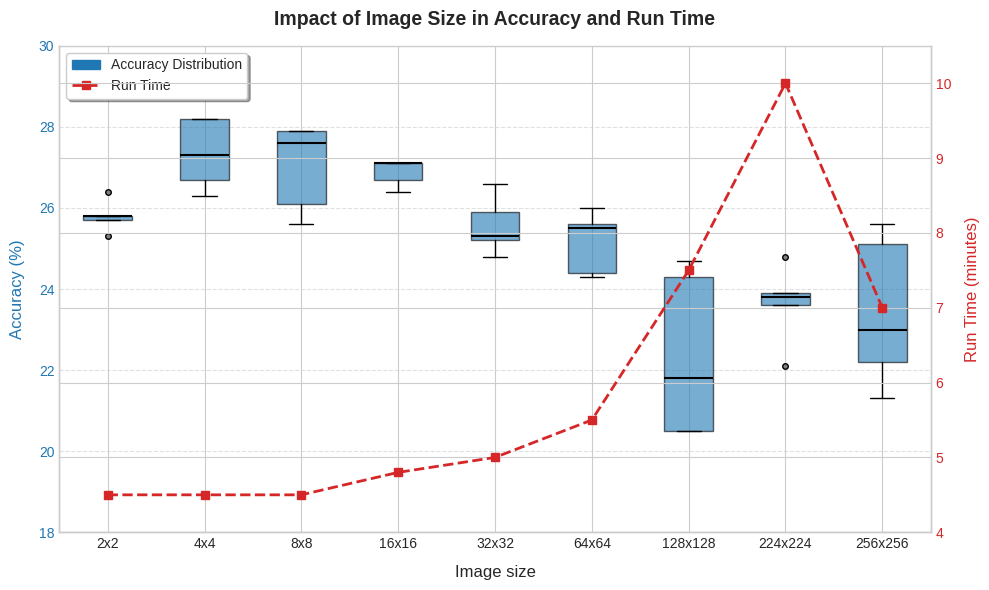

In [6]:
performance_image_size = {
    'Data':{
        'Accuracy':{
            '2x2': [25.7, 25.8, 25.3, 25.8, 26.4],
            '4x4': [26.7, 26.3, 28.2, 28.2, 27.3],
            '8x8': [27.9, 26.1, 27.9, 25.6, 27.6],
            '16x16': [26.7, 26.4, 27.1, 27.1, 27.1],
            '32x32':[25.3, 26.6, 25.2, 24.8, 25.9],
            '64x64':[24.4, 26.0, 25.6, 25.5, 24.3],
            '128x128':[24.3, 20.5, 24.7, 20.5, 21.8],
            '224x224':[23.8, 22.1, 23.6, 24.8, 23.9],
            '256x256':[25.6, 22.2, 23.0, 21.3, 25.1],
        },
        'Runtime':{
            '2x2': 4.5,
            '4x4': 4.5,
            '8x8': 4.5, 
            '16x16': 4.8,
            '32x32': 5,
            '64x64': 5.5,
            '128x128': 7.5, 
            '224x224': 10,
            '256x256': 7
        }
    }
}

plot_spatial_pyramids_boxplots(performance_image_size, title="Impact of Image Size in Accuracy and Run Time", 
                               y1_dim=[18,30], y2_dim=[4, 10.5], x_text="", x_axis_label="Image size", bp_width=0.5)